## NNDL - HW4 - Q1
# Sentiment Analysis

## Install Packages

In [1]:
!pip install hazm
!pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 12.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0

## Import Packages and Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import emoji
from hazm import Normalizer, Stemmer, word_tokenize, stopwords_list
from transformers import AutoTokenizer
from transformers import AutoModel
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load Dataset

In [4]:
anger = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/anger.csv')
disgust = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/disgust.csv')
fear = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/fear.csv')
joy = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/joy.csv')
sad = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/sad.csv')
surprise = pd.read_csv('/kaggle/input/persian-tweets-emotional-dataset/surprise.csv')

tweets = pd.concat([anger, disgust, fear, joy, sad, surprise], ignore_index=True)
tweets.head()

,tweet,replyCount,retweetCount,likeCount,quoteCount,hashtags,sourceLabel,emotion
0,دیشب خواب دیدم بمبی چیزی زدن نورش خیلی خیره کن...,0,3,2,0,['No2IR'],Twitter Web App,anger
1,تبر زدی بر ریشه‌اَم، جوانه رویید جایِ زخم\nران...,0,0,8,0,['سين_کاف'],Twitter for Android,anger
2,پدر سوخته ای که بابام بهم میگه دو معنی داره که...,1,0,11,0,['پدر_ایرانی'],Twitter for Android,anger
3,با خود مواجه شوید و اخم نکنید. اقتدار در نگاه ...,0,0,1,0,"['جذبه', 'اخم']",Twitter for iPhone,anger
4,مدح تو را در شادی و در غم نوشتند\nبا این همه ا...,4,6,36,0,['نبأ_عظیم'],Twitter Web App,anger


In [5]:
print(tweets.columns)
print(tweets.shape)

Index(['tweet', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'hashtags', 'sourceLabel', 'emotion'],
      dtype='object')
(113829, 8)


### Dataset from 'tweet' and 'emotion' columns 

In [6]:
data = tweets[['tweet', 'emotion']].copy()
print(data.shape)
data.head()

(113829, 2)


,tweet,emotion
0,دیشب خواب دیدم بمبی چیزی زدن نورش خیلی خیره کن...,anger
1,تبر زدی بر ریشه‌اَم، جوانه رویید جایِ زخم\nران...,anger
2,پدر سوخته ای که بابام بهم میگه دو معنی داره که...,anger
3,با خود مواجه شوید و اخم نکنید. اقتدار در نگاه ...,anger
4,مدح تو را در شادی و در غم نوشتند\nبا این همه ا...,anger


### Distribution of Emotions

In [7]:
unique_emotions = data['emotion'].unique()
print(unique_emotions)

['anger' 'disgust' 'fear' 'joy' 'sad' 'surprise']


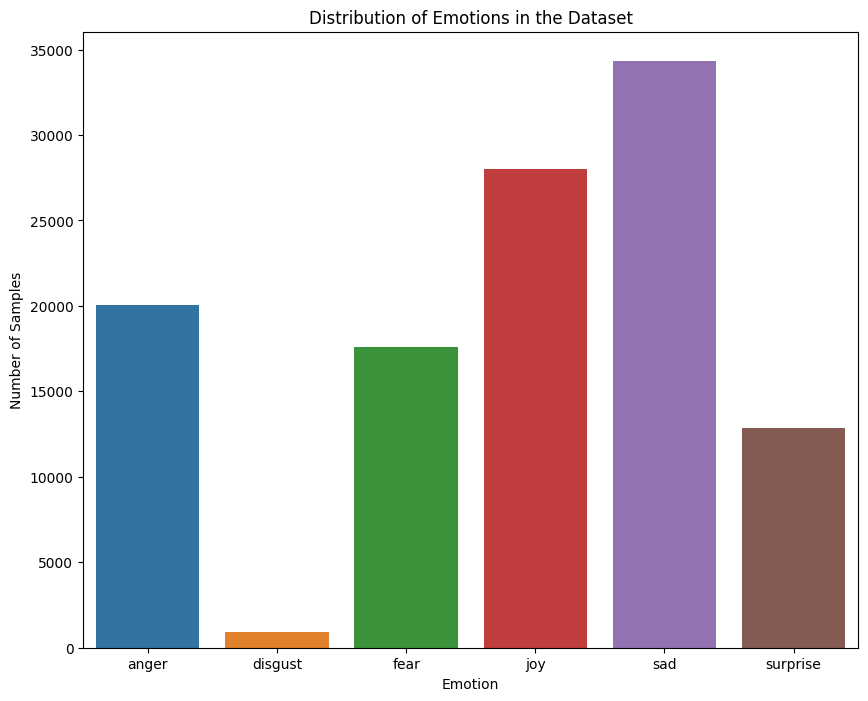

In [8]:
plt.figure(figsize=(10, 8))

sns.countplot(x='emotion', data=data)
plt.title('Distribution of Emotions in the Dataset')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')

plt.show()

In [9]:
emotion_counts = data['emotion'].value_counts()
print(emotion_counts)

emotion
sad         34328
joy         28024
anger       20069
fear        17624
surprise    12859
disgust       925
Name: count, dtype: int64


# Preprocessing 

## Removing all HTMLs and URLs

In [10]:
def remove_html_urls(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  
    text = re.sub(r'<.*?>', '', text)  
    return text

example_text = "لینک زیر یک لینک تست است: https://test.com <html> test </html>"
print("Before:", example_text)
print("After:", remove_html_urls(example_text))

Before: لینک زیر یک لینک تست است: https://test.com <html> test </html>
After: لینک زیر یک لینک تست است:   test 


## Removing Repetitive Characters

In [11]:
def remove_repetitive_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)

example_text = "امروووووز هوا خیلییییی خوبههههه"
print("Before:", example_text)
print("After:", remove_repetitive_chars(example_text))

Before: امروووووز هوا خیلییییی خوبههههه
After: امروز هوا خیلی خوبه


## Removing Stopwords

In [12]:
stopwords_persian = stopwords_list()
def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords_persian]
    return ' '.join(tokens)

example_text = "این یک مثال برای حذف ایست واژه است"
print("Before:", example_text)
print("After:", remove_stopwords(example_text))

Before: این یک مثال برای حذف ایست واژه است
After: مثال حذف ایست واژه


## Replacing Emojis with Text

In [13]:
def replace_emojis(text):
    return emoji.demojize(text)

example_text = "چقدر خوبه هوا😍😊"
print("Before:", example_text)
print("After:", replace_emojis(example_text))

Before: چقدر خوبه هوا😍😊
After: چقدر خوبه هوا:smiling_face_with_heart-eyes::smiling_face_with_smiling_eyes:


## Stemming ( Using Hazm Stemmer )

In [14]:
stemmer = Stemmer()

def stem_text(text):
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

example_text = "کتاب‌ها"
print("Before:", example_text)
print("After:", stem_text(example_text))

Before: کتاب‌ها
After: کتاب


## Incorrect Spellings  (Using Hazm Normalizer)

In [15]:
normalizer = Normalizer()

def correct_spelling(text):
    return normalizer.normalize(text)

example_text = "جمعهها تعطیل است"
print("Before:", example_text)
print("After:", correct_spelling(example_text))

Before: جمعهها تعطیل است
After: جمعه‌ها تعطیل است


In [16]:
def preprocess_text(text):
    text = remove_html_urls(text)
    text = remove_repetitive_chars(text)
    text = replace_emojis(text)
    text = correct_spelling(text)
    text = remove_stopwords(text)
   # text = stem_text(text)
    return text

# Example
example_text = "لینک های ناشناس خطرناک هستند https://test.com 😊"
print("Before:", example_text)
print("After:", preprocess_text(example_text))

Before: لینک های ناشناس خطرناک هستند https://test.com 😊
After: لینک‌های ناشناس خطرناک : smiling_face_with_smiling_eyes :


In [17]:
data.loc[:, 'cleaned_tweet'] = data['tweet'].apply(preprocess_text)

In [18]:
data.head()

,tweet,emotion,cleaned_tweet
0,دیشب خواب دیدم بمبی چیزی زدن نورش خیلی خیره کن...,anger,دیشب خواب دیدم بمبی زدن نورش خیره کنده س سبزه ...
1,تبر زدی بر ریشه‌اَم، جوانه رویید جایِ زخم\nران...,anger,تبر زدی ریشه‌ام ، جوانه روید زخم راندی مرا دل ...
2,پدر سوخته ای که بابام بهم میگه دو معنی داره که...,anger,پدر سوخته‌ای بابام بهم میگه معنی داره خودم شرا...
3,با خود مواجه شوید و اخم نکنید. اقتدار در نگاه ...,anger,شوید اخم نکنید . اقتدار نگاه‌ات چشمانت . بگذار...
4,مدح تو را در شادی و در غم نوشتند\nبا این همه ا...,anger,مدح شادی غم نوشتند برایت نوشتند خنده لبت ، تصن...


In [19]:
#Save
#data.to_csv('preprocessed_tweets.csv', index=False)
#Read data
#data = pd.read_csv('preprocessed_tweets.csv')
#data.head()

# Feature Representation

##  Tokenization with ParsBERT

In [20]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
MAX_LEN = 32

def tokenize_and_pad(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,  
            max_length=max_len,       
            padding='max_length',     
            truncation=True,          
            return_attention_mask=True,  
            return_tensors='pt'       
        )
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return torch.cat(input_ids, dim=0).to(device), torch.cat(attention_masks, dim=0).to(device)

config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

In [21]:
input_ids, attention_masks = tokenize_and_pad(data['cleaned_tweet'], tokenizer, MAX_LEN)

print("Tokenization and padding complete.")
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)

Tokenization and padding complete.
Input IDs shape: torch.Size([113829, 32])
Attention Masks shape: torch.Size([113829, 32])


In [22]:
input_ids[1]

tensor([    2, 14660, 32698,  5975,  2035,   300, 20547,  5668,  9700, 11293,
         1158,  2700,  2420,   300, 10781, 12411, 11986, 30538,     1,  2958,
            1,  8035,     4,     0,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')

In [23]:
attention_masks[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

## Embeddings with ParsBERT


In [24]:
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased").to(device)

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

def get_embeddings_in_batches(data, tokenizer, model, max_len, batch_size, device):
    num_batches = len(data) // batch_size + 1
    all_embeddings = []

    for i in range(num_batches):
        batch_texts = data['cleaned_tweet'][i*batch_size:(i+1)*batch_size]
        input_ids, attention_masks = tokenize_and_pad(batch_texts, tokenizer, max_len)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            batch_embeddings = outputs.last_hidden_state[:, :, :120]
        
        all_embeddings.append(batch_embeddings.cpu())
        
        clear_memory()

    embeddings = torch.cat(all_embeddings, dim=0)
    return embeddings


pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [25]:
batch_size = 64
embeddings = get_embeddings_in_batches(data, tokenizer, model, MAX_LEN, batch_size, device)

print("All embeddings shape:", embeddings.shape)

All embeddings shape: torch.Size([113829, 32, 120])


In [26]:
# Save embeddings
#torch.save(embeddings, 'embeddings.pt')
#loaded_embeddings = torch.load('embeddings.pt')

# Model Construction

## Split Data ( 70 - 30 )

In [27]:
labels = data['emotion'].factorize()[0] 

train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.3, random_state=42)
train_embeddings, val_embeddings, train_labels, val_labels = train_test_split(train_embeddings, train_labels, test_size=0.2, random_state=42)

## Create Datasets

In [30]:
train_embeddings_tensor = train_embeddings.clone().detach()
train_labels_tensor = torch.tensor(train_labels).clone().detach()

val_embeddings_tensor = val_embeddings.clone().detach()
val_labels_tensor = torch.tensor(val_labels).clone().detach()

test_embeddings_tensor = test_embeddings.clone().detach()
test_labels_tensor = torch.tensor(test_labels).clone().detach()

train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_embeddings_tensor, test_labels_tensor)

## DataLoaders ( Batch Size= 8-16 ) 

In [31]:
#batch_size = 64
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Define the DataLoader function to create DataLoaders for different batch sizes

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

### Test dataloader function

In [32]:
batch_size = 64
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size)

data_iter = iter(train_dataloader)
sample_embeddings, sample_labels = next(data_iter)

sample_embeddings = sample_embeddings.to(device)
sample_labels = sample_labels.to(device)
print("Sample embedding shape:", sample_embeddings.shape)  
print("Sample label shape:", sample_labels.shape)  

Sample embedding shape: torch.Size([64, 32, 120])
Sample label shape: torch.Size([64])


## CNN-LSTM Model

In [33]:
class CNNLSTM(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(CNNLSTM, self).__init__()
        
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=32, hidden_size=100, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1d(x)
        x = self.maxpool(x)
        x = x.permute(0, 2, 1) 
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        x = self.fc(x)
        return x

In [39]:
embedding_dim = 120 
num_classes = 6  
model = CNNLSTM(embedding_dim, num_classes)
model.to(device)

summary(model, input_size=(64, 32, embedding_dim))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [64, 6]                   --
├─Conv1d: 1-1                            [64, 32, 32]              11,552
├─MaxPool1d: 1-2                         [64, 32, 16]              --
├─LSTM: 1-3                              [64, 16, 100]             53,600
├─Dropout: 1-4                           [64, 100]                 --
├─Linear: 1-5                            [64, 6]                   606
Total params: 65,758
Trainable params: 65,758
Non-trainable params: 0
Total mult-adds (M): 78.58
Input size (MB): 0.98
Forward/backward pass size (MB): 1.35
Params size (MB): 0.26
Estimated Total Size (MB): 2.59

## Train Loop

In [40]:
def plot_results(epochs, train_loss, val_loss, train_accuracy, val_accuracy, title):
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [73]:
criterion = nn.CrossEntropyLoss()

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10 , lr_plot = 0.001):
    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_train_preds = []
        all_train_labels = []

        for embeddings, labels in train_dataloader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_dataloader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    model.load_state_dict(best_model_state)
    
    epochs = range(1, num_epochs + 1)
    plot_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies, f'Batch Size={batch_size}, LR={lr_plot}, Optimizer={optimizer.__class__.__name__}')
    
    return model

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

In [74]:
def train_and_evaluate(model, train_dataset, val_dataset, test_dataset, batch_size, learning_rate, optimizer_class, num_epochs=10):
    train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    trained_model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, lr_plot = learning_rate)
    
    test_loss, test_accuracy = evaluate_model(trained_model, test_dataloader, criterion)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    return trained_model

## Greedy search for optimal hyperparameter

Training with batch_size=8, learning_rate=0.001, optimizer=Adam
Epoch 1/10, Train Loss: 1.0231, Train Accuracy: 0.6122, Val Loss: 0.7594, Val Accuracy: 0.7290
Epoch 2/10, Train Loss: 0.6927, Train Accuracy: 0.7539, Val Loss: 0.6555, Val Accuracy: 0.7701
Epoch 3/10, Train Loss: 0.6204, Train Accuracy: 0.7802, Val Loss: 0.6373, Val Accuracy: 0.7772
Epoch 4/10, Train Loss: 0.5791, Train Accuracy: 0.7955, Val Loss: 0.6251, Val Accuracy: 0.7790
Epoch 5/10, Train Loss: 0.5450, Train Accuracy: 0.8071, Val Loss: 0.6189, Val Accuracy: 0.7866
Epoch 6/10, Train Loss: 0.5202, Train Accuracy: 0.8164, Val Loss: 0.6154, Val Accuracy: 0.7874
Epoch 7/10, Train Loss: 0.4987, Train Accuracy: 0.8234, Val Loss: 0.6214, Val Accuracy: 0.7855
Epoch 8/10, Train Loss: 0.4846, Train Accuracy: 0.8289, Val Loss: 0.6338, Val Accuracy: 0.7846
Epoch 9/10, Train Loss: 0.4729, Train Accuracy: 0.8318, Val Loss: 0.6256, Val Accuracy: 0.7868
Epoch 10/10, Train Loss: 0.4596, Train Accuracy: 0.8365, Val Loss: 0.6452, Val Ac

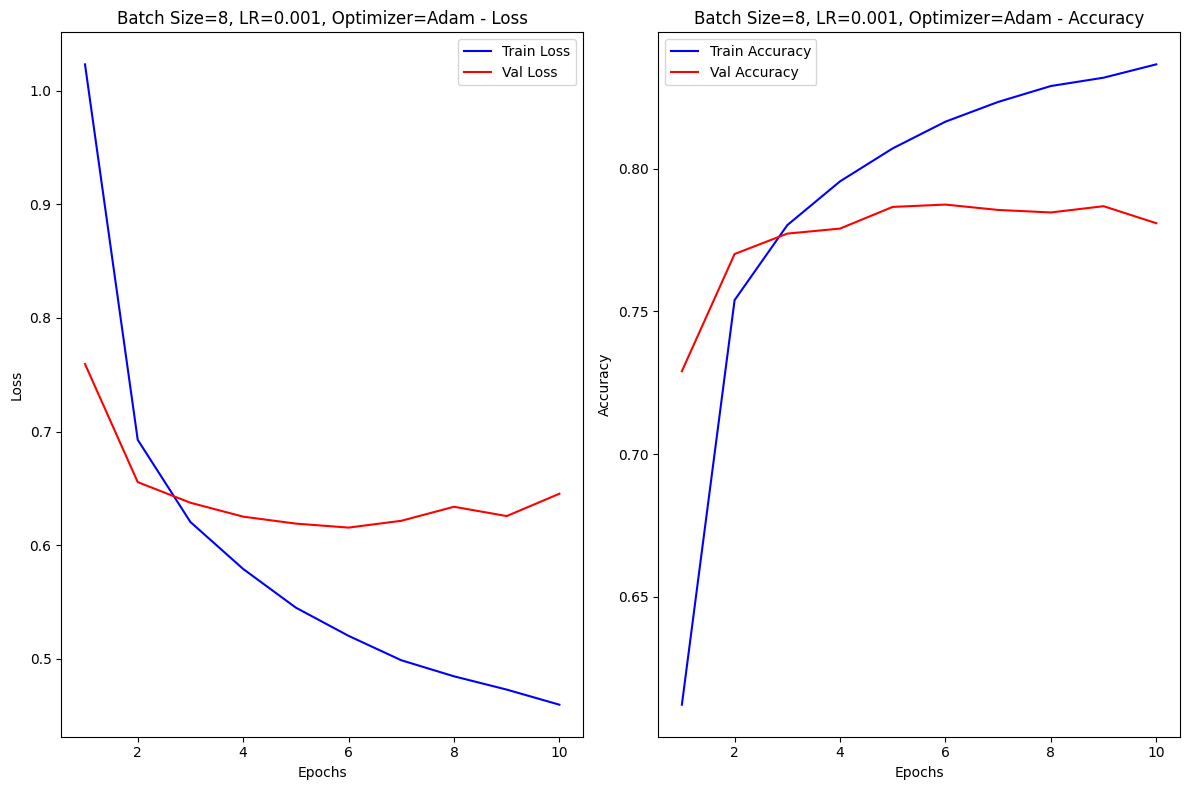

Training with batch_size=8, learning_rate=0.001, optimizer=SGD
Epoch 1/10, Train Loss: 1.6181, Train Accuracy: 0.3042, Val Loss: 1.5757, Val Accuracy: 0.3178
Epoch 2/10, Train Loss: 1.5554, Train Accuracy: 0.3421, Val Loss: 1.5295, Val Accuracy: 0.3562
Epoch 3/10, Train Loss: 1.4939, Train Accuracy: 0.3728, Val Loss: 1.4512, Val Accuracy: 0.3864
Epoch 4/10, Train Loss: 1.4193, Train Accuracy: 0.4138, Val Loss: 1.3763, Val Accuracy: 0.4359
Epoch 5/10, Train Loss: 1.3343, Train Accuracy: 0.4701, Val Loss: 1.2785, Val Accuracy: 0.5013
Epoch 6/10, Train Loss: 1.2614, Train Accuracy: 0.5114, Val Loss: 1.2200, Val Accuracy: 0.5309
Epoch 7/10, Train Loss: 1.2233, Train Accuracy: 0.5278, Val Loss: 1.1913, Val Accuracy: 0.5432
Epoch 8/10, Train Loss: 1.1965, Train Accuracy: 0.5400, Val Loss: 1.1818, Val Accuracy: 0.5439
Epoch 9/10, Train Loss: 1.1719, Train Accuracy: 0.5497, Val Loss: 1.1687, Val Accuracy: 0.5497
Epoch 10/10, Train Loss: 1.1481, Train Accuracy: 0.5622, Val Loss: 1.1328, Val Acc

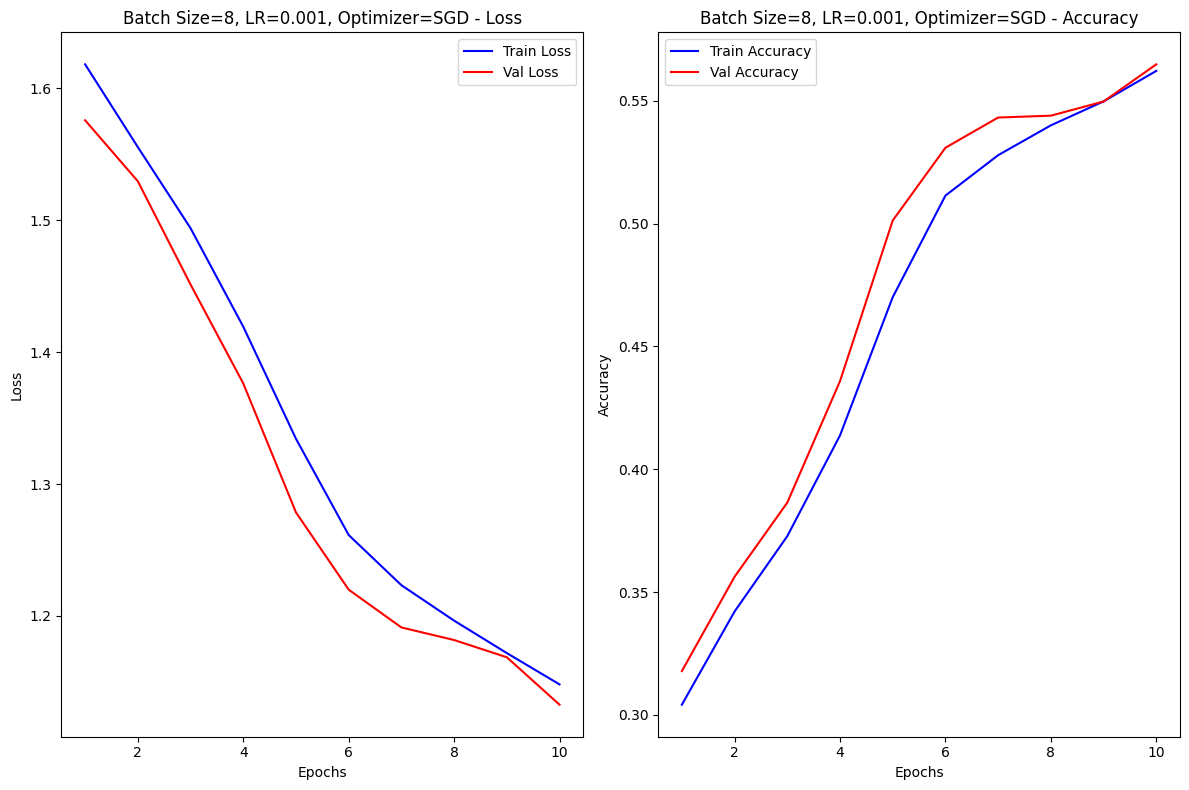

Training with batch_size=8, learning_rate=0.0001, optimizer=Adam
Epoch 1/10, Train Loss: 1.3208, Train Accuracy: 0.4731, Val Loss: 1.2106, Val Accuracy: 0.5265
Epoch 2/10, Train Loss: 1.1661, Train Accuracy: 0.5511, Val Loss: 1.1269, Val Accuracy: 0.5671
Epoch 3/10, Train Loss: 1.0686, Train Accuracy: 0.5946, Val Loss: 1.0006, Val Accuracy: 0.6231
Epoch 4/10, Train Loss: 0.9552, Train Accuracy: 0.6461, Val Loss: 0.9085, Val Accuracy: 0.6615
Epoch 5/10, Train Loss: 0.8611, Train Accuracy: 0.6867, Val Loss: 0.8356, Val Accuracy: 0.6947
Epoch 6/10, Train Loss: 0.7923, Train Accuracy: 0.7162, Val Loss: 0.7732, Val Accuracy: 0.7231
Epoch 7/10, Train Loss: 0.7379, Train Accuracy: 0.7368, Val Loss: 0.7505, Val Accuracy: 0.7325
Epoch 8/10, Train Loss: 0.6958, Train Accuracy: 0.7540, Val Loss: 0.7173, Val Accuracy: 0.7467
Epoch 9/10, Train Loss: 0.6616, Train Accuracy: 0.7664, Val Loss: 0.6964, Val Accuracy: 0.7531
Epoch 10/10, Train Loss: 0.6329, Train Accuracy: 0.7754, Val Loss: 0.6832, Val A

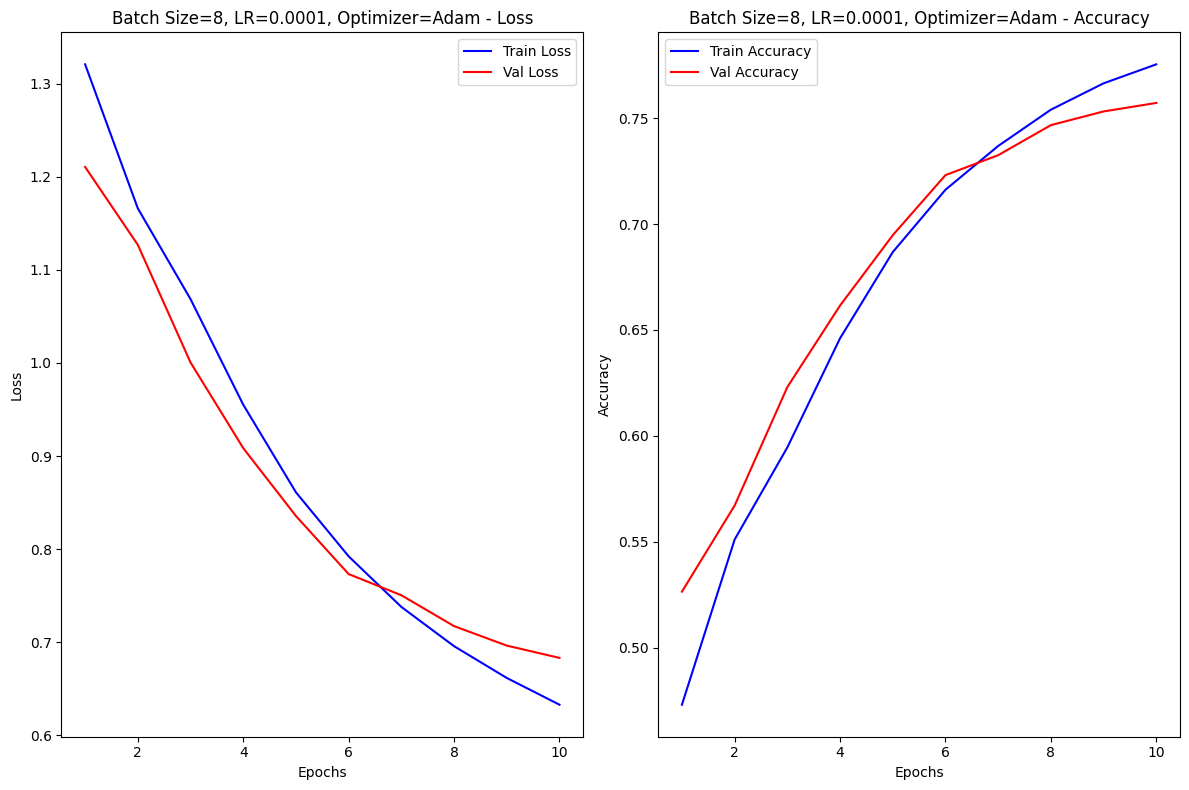

Training with batch_size=8, learning_rate=0.0001, optimizer=SGD
Epoch 1/10, Train Loss: 1.7457, Train Accuracy: 0.3008, Val Loss: 1.7110, Val Accuracy: 0.3048
Epoch 2/10, Train Loss: 1.6860, Train Accuracy: 0.3008, Val Loss: 1.6621, Val Accuracy: 0.3048
Epoch 3/10, Train Loss: 1.6459, Train Accuracy: 0.3008, Val Loss: 1.6314, Val Accuracy: 0.3048
Epoch 4/10, Train Loss: 1.6217, Train Accuracy: 0.3008, Val Loss: 1.6135, Val Accuracy: 0.3048
Epoch 5/10, Train Loss: 1.6074, Train Accuracy: 0.3009, Val Loss: 1.6025, Val Accuracy: 0.3048
Epoch 6/10, Train Loss: 1.5984, Train Accuracy: 0.3010, Val Loss: 1.5952, Val Accuracy: 0.3048
Epoch 7/10, Train Loss: 1.5921, Train Accuracy: 0.3012, Val Loss: 1.5899, Val Accuracy: 0.3048
Epoch 8/10, Train Loss: 1.5875, Train Accuracy: 0.3013, Val Loss: 1.5858, Val Accuracy: 0.3049
Epoch 9/10, Train Loss: 1.5839, Train Accuracy: 0.3029, Val Loss: 1.5825, Val Accuracy: 0.3057
Epoch 10/10, Train Loss: 1.5810, Train Accuracy: 0.3038, Val Loss: 1.5794, Val Ac

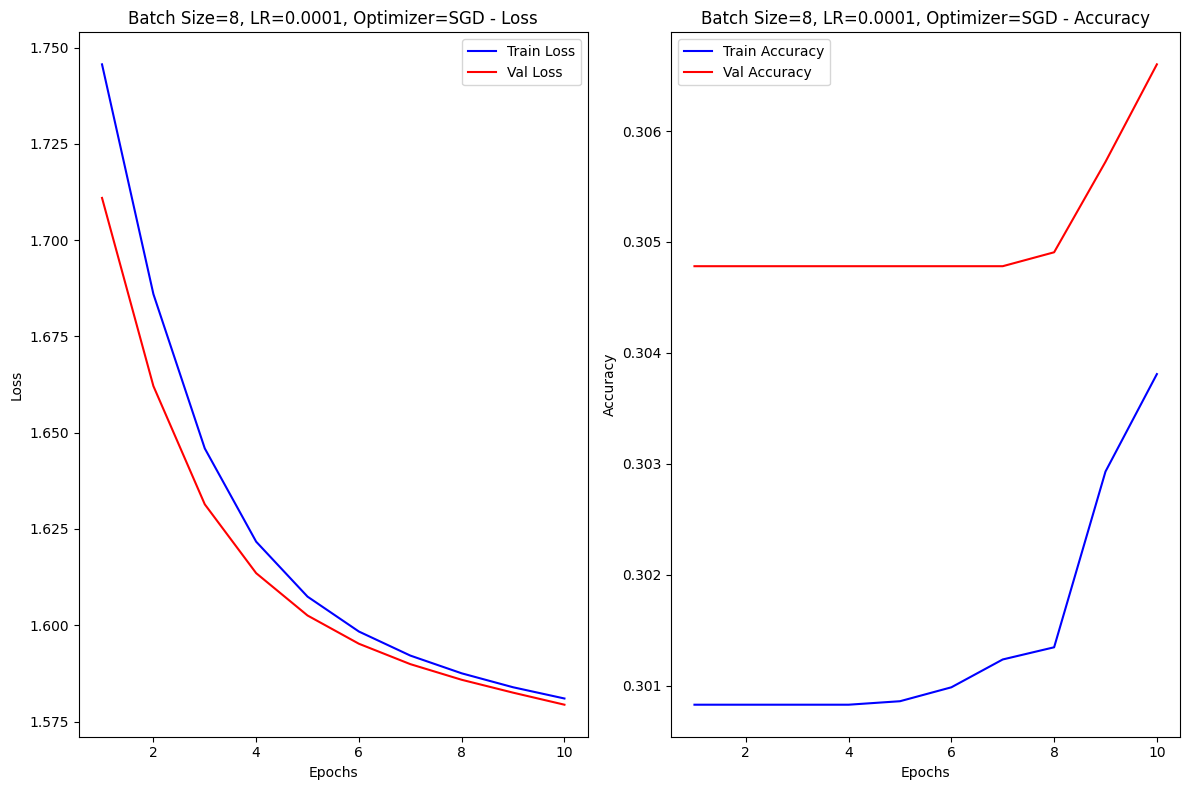

Training with batch_size=64, learning_rate=0.001, optimizer=Adam
Epoch 1/10, Train Loss: 1.2187, Train Accuracy: 0.5251, Val Loss: 0.9531, Val Accuracy: 0.6472
Epoch 2/10, Train Loss: 0.8577, Train Accuracy: 0.6901, Val Loss: 0.7699, Val Accuracy: 0.7245
Epoch 3/10, Train Loss: 0.7156, Train Accuracy: 0.7454, Val Loss: 0.6951, Val Accuracy: 0.7539
Epoch 4/10, Train Loss: 0.6404, Train Accuracy: 0.7730, Val Loss: 0.6509, Val Accuracy: 0.7674
Epoch 5/10, Train Loss: 0.5943, Train Accuracy: 0.7902, Val Loss: 0.6498, Val Accuracy: 0.7666
Epoch 6/10, Train Loss: 0.5587, Train Accuracy: 0.8026, Val Loss: 0.6354, Val Accuracy: 0.7752
Epoch 7/10, Train Loss: 0.5295, Train Accuracy: 0.8130, Val Loss: 0.6160, Val Accuracy: 0.7818
Epoch 8/10, Train Loss: 0.5000, Train Accuracy: 0.8238, Val Loss: 0.6278, Val Accuracy: 0.7852
Epoch 9/10, Train Loss: 0.4739, Train Accuracy: 0.8331, Val Loss: 0.6472, Val Accuracy: 0.7779
Epoch 10/10, Train Loss: 0.4533, Train Accuracy: 0.8407, Val Loss: 0.6502, Val A

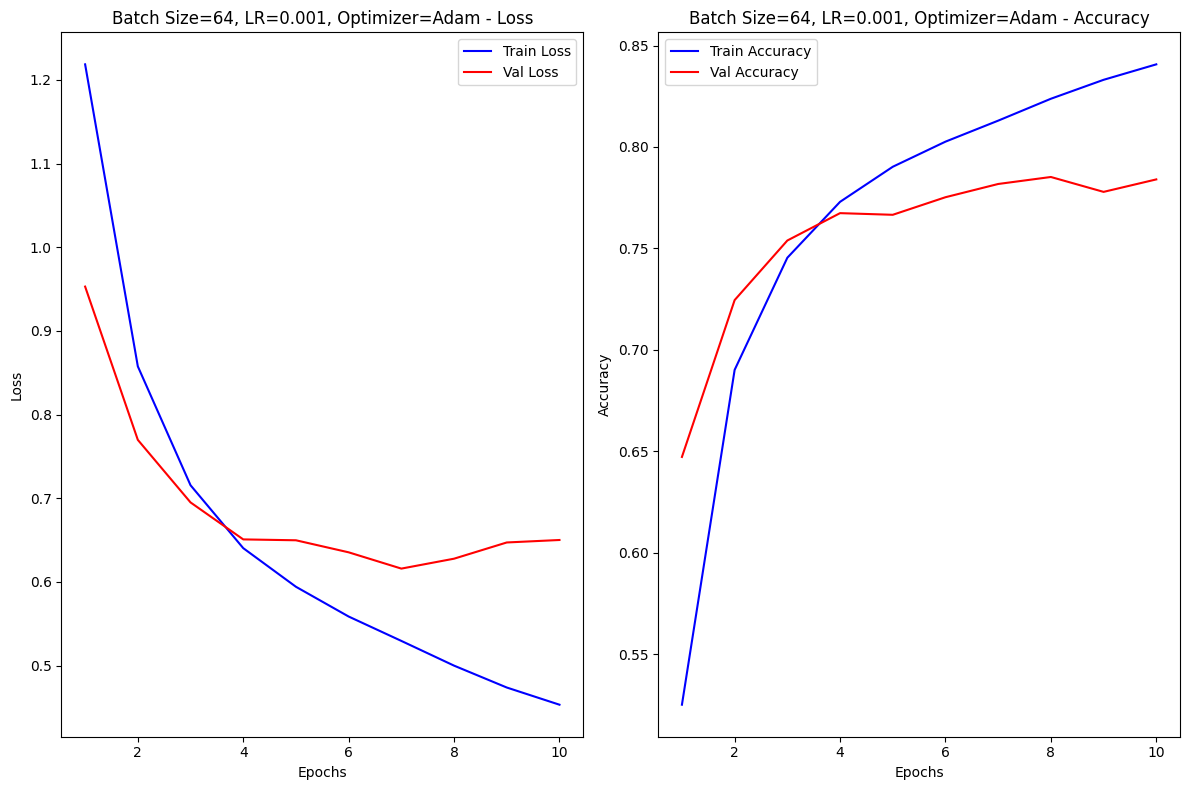

Training with batch_size=64, learning_rate=0.001, optimizer=SGD
Epoch 1/10, Train Loss: 1.7316, Train Accuracy: 0.2951, Val Loss: 1.6798, Val Accuracy: 0.3048
Epoch 2/10, Train Loss: 1.6492, Train Accuracy: 0.3008, Val Loss: 1.6262, Val Accuracy: 0.3048
Epoch 3/10, Train Loss: 1.6148, Train Accuracy: 0.3009, Val Loss: 1.6060, Val Accuracy: 0.3048
Epoch 4/10, Train Loss: 1.6000, Train Accuracy: 0.3013, Val Loss: 1.5956, Val Accuracy: 0.3048
Epoch 5/10, Train Loss: 1.5923, Train Accuracy: 0.3016, Val Loss: 1.5893, Val Accuracy: 0.3048
Epoch 6/10, Train Loss: 1.5868, Train Accuracy: 0.3029, Val Loss: 1.5849, Val Accuracy: 0.3052
Epoch 7/10, Train Loss: 1.5830, Train Accuracy: 0.3058, Val Loss: 1.5814, Val Accuracy: 0.3064
Epoch 8/10, Train Loss: 1.5799, Train Accuracy: 0.3094, Val Loss: 1.5782, Val Accuracy: 0.3125
Epoch 9/10, Train Loss: 1.5766, Train Accuracy: 0.3175, Val Loss: 1.5747, Val Accuracy: 0.3192
Epoch 10/10, Train Loss: 1.5726, Train Accuracy: 0.3237, Val Loss: 1.5710, Val Ac

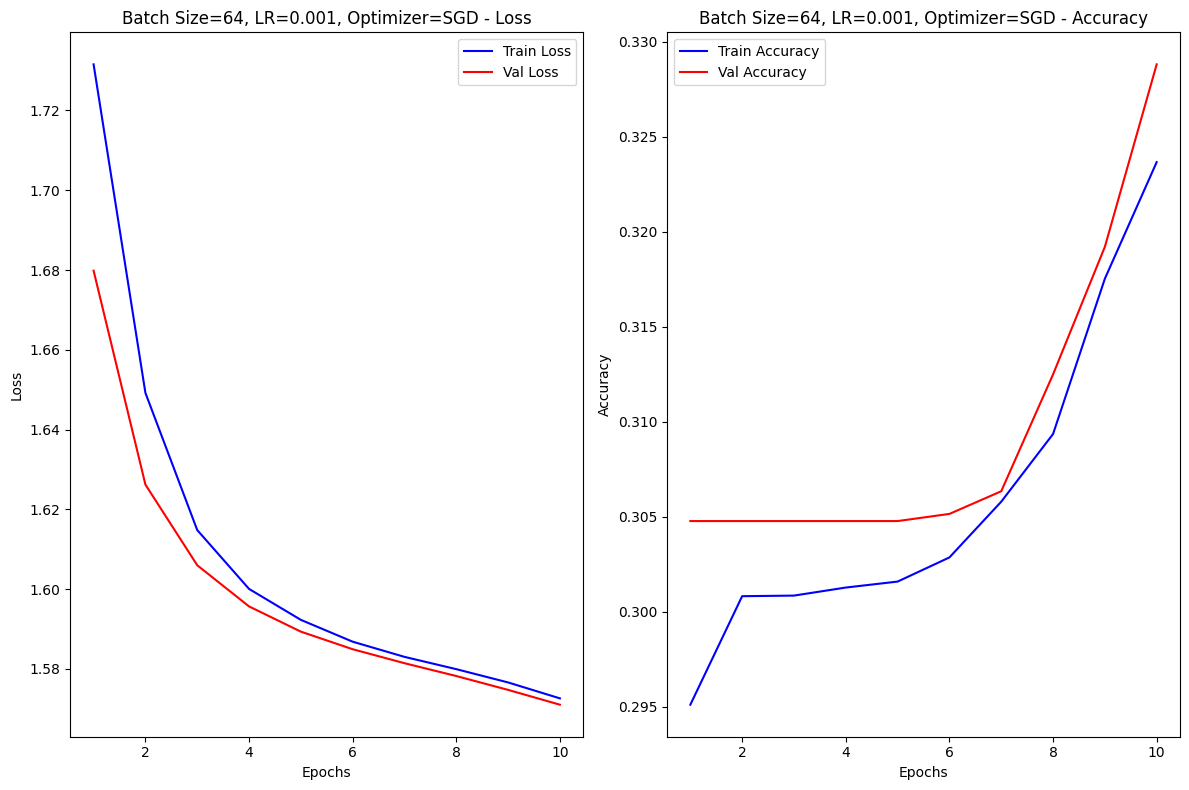

Training with batch_size=64, learning_rate=0.0001, optimizer=Adam
Epoch 1/10, Train Loss: 1.4256, Train Accuracy: 0.4189, Val Loss: 1.2893, Val Accuracy: 0.4974
Epoch 2/10, Train Loss: 1.2551, Train Accuracy: 0.5108, Val Loss: 1.2163, Val Accuracy: 0.5251
Epoch 3/10, Train Loss: 1.2000, Train Accuracy: 0.5353, Val Loss: 1.1828, Val Accuracy: 0.5397
Epoch 4/10, Train Loss: 1.1682, Train Accuracy: 0.5492, Val Loss: 1.1588, Val Accuracy: 0.5503
Epoch 5/10, Train Loss: 1.1438, Train Accuracy: 0.5590, Val Loss: 1.1412, Val Accuracy: 0.5581
Epoch 6/10, Train Loss: 1.1177, Train Accuracy: 0.5706, Val Loss: 1.1129, Val Accuracy: 0.5692
Epoch 7/10, Train Loss: 1.0936, Train Accuracy: 0.5799, Val Loss: 1.0949, Val Accuracy: 0.5780
Epoch 8/10, Train Loss: 1.0678, Train Accuracy: 0.5929, Val Loss: 1.0691, Val Accuracy: 0.5898
Epoch 9/10, Train Loss: 1.0397, Train Accuracy: 0.6055, Val Loss: 1.0486, Val Accuracy: 0.5996
Epoch 10/10, Train Loss: 1.0114, Train Accuracy: 0.6189, Val Loss: 1.0218, Val 

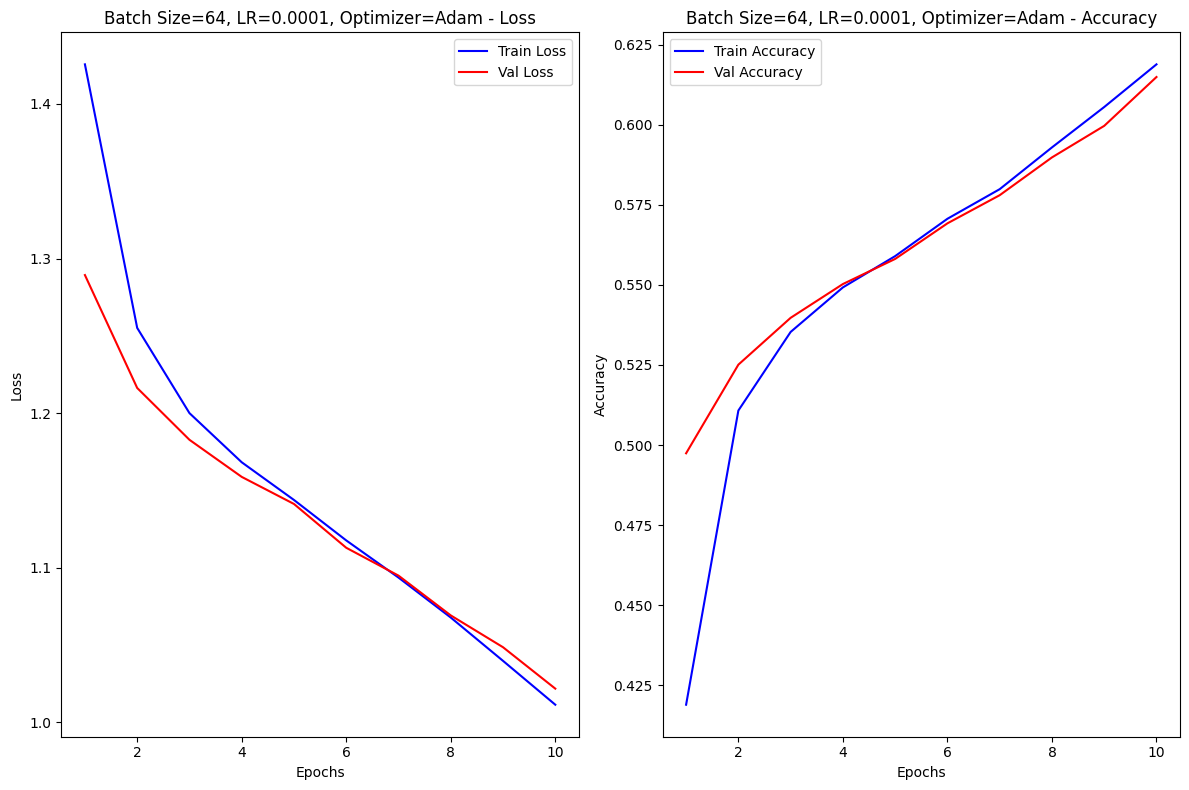

Training with batch_size=64, learning_rate=0.0001, optimizer=SGD
Epoch 1/10, Train Loss: 1.7986, Train Accuracy: 0.1194, Val Loss: 1.7932, Val Accuracy: 0.1190
Epoch 2/10, Train Loss: 1.7882, Train Accuracy: 0.1229, Val Loss: 1.7831, Val Accuracy: 0.1231
Epoch 3/10, Train Loss: 1.7784, Train Accuracy: 0.1363, Val Loss: 1.7736, Val Accuracy: 0.1408
Epoch 4/10, Train Loss: 1.7691, Train Accuracy: 0.1677, Val Loss: 1.7646, Val Accuracy: 0.1802
Epoch 5/10, Train Loss: 1.7603, Train Accuracy: 0.2077, Val Loss: 1.7561, Val Accuracy: 0.2203
Epoch 6/10, Train Loss: 1.7518, Train Accuracy: 0.2427, Val Loss: 1.7478, Val Accuracy: 0.2526
Epoch 7/10, Train Loss: 1.7436, Train Accuracy: 0.2632, Val Loss: 1.7399, Val Accuracy: 0.2706
Epoch 8/10, Train Loss: 1.7359, Train Accuracy: 0.2738, Val Loss: 1.7322, Val Accuracy: 0.2860
Epoch 9/10, Train Loss: 1.7283, Train Accuracy: 0.2829, Val Loss: 1.7248, Val Accuracy: 0.2978
Epoch 10/10, Train Loss: 1.7209, Train Accuracy: 0.2885, Val Loss: 1.7175, Val A

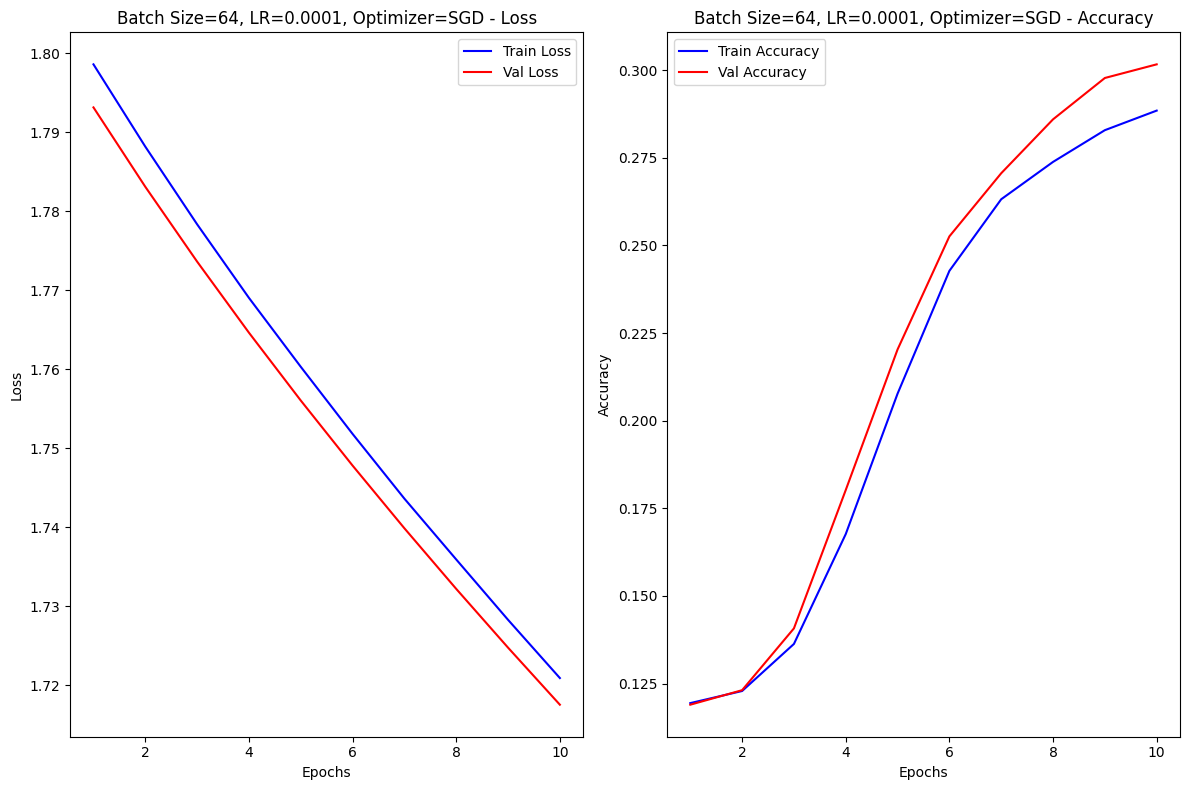

Best Hyperparameters: Batch Size=8, Learning Rate=0.001, Optimizer=Adam


In [43]:
best_val_loss = float('inf')
best_hyperparams = None
best_model_state = None

batch_sizes = [8, 64]
learning_rates = [0.001, 0.0001]
optimizers = [optim.Adam, optim.SGD]

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        for Optimizer in optimizers:
            print(f'Training with batch_size={batch_size}, learning_rate={learning_rate}, optimizer={Optimizer.__name__}')
            
            train_dataloader, val_dataloader, test_dataloader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size)
            
            model = CNNLSTM(embedding_dim, num_classes).to(device)
            optimizer = Optimizer(model.parameters(), lr=learning_rate)
            
            num_epochs = 10 
            trained_model = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, learning_rate )
            val_loss, val_accuracy = evaluate_model(trained_model, val_dataloader, criterion)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_hyperparams = (batch_size, learning_rate, Optimizer.__name__)
                best_model_state = trained_model.state_dict()

print(f'Best Hyperparameters: Batch Size={best_hyperparams[0]}, Learning Rate={best_hyperparams[1]}, Optimizer={best_hyperparams[2]}')

## Train CNN-LSTM Model- 20 Epcochs

Epoch 1/20, Train Loss: 1.2153, Train Accuracy: 0.5245, Val Loss: 0.9559, Val Accuracy: 0.6429
Epoch 2/20, Train Loss: 0.8253, Train Accuracy: 0.7038, Val Loss: 0.7302, Val Accuracy: 0.7413
Epoch 3/20, Train Loss: 0.6850, Train Accuracy: 0.7568, Val Loss: 0.6712, Val Accuracy: 0.7602
Epoch 4/20, Train Loss: 0.6174, Train Accuracy: 0.7808, Val Loss: 0.6336, Val Accuracy: 0.7763
Epoch 5/20, Train Loss: 0.5751, Train Accuracy: 0.7980, Val Loss: 0.6140, Val Accuracy: 0.7839
Epoch 6/20, Train Loss: 0.5379, Train Accuracy: 0.8133, Val Loss: 0.6125, Val Accuracy: 0.7867
Epoch 7/20, Train Loss: 0.5082, Train Accuracy: 0.8207, Val Loss: 0.6110, Val Accuracy: 0.7880
Epoch 8/20, Train Loss: 0.4813, Train Accuracy: 0.8314, Val Loss: 0.6101, Val Accuracy: 0.7883
Epoch 9/20, Train Loss: 0.4570, Train Accuracy: 0.8405, Val Loss: 0.6145, Val Accuracy: 0.7878
Epoch 10/20, Train Loss: 0.4356, Train Accuracy: 0.8479, Val Loss: 0.6371, Val Accuracy: 0.7875
Epoch 11/20, Train Loss: 0.4147, Train Accuracy: 

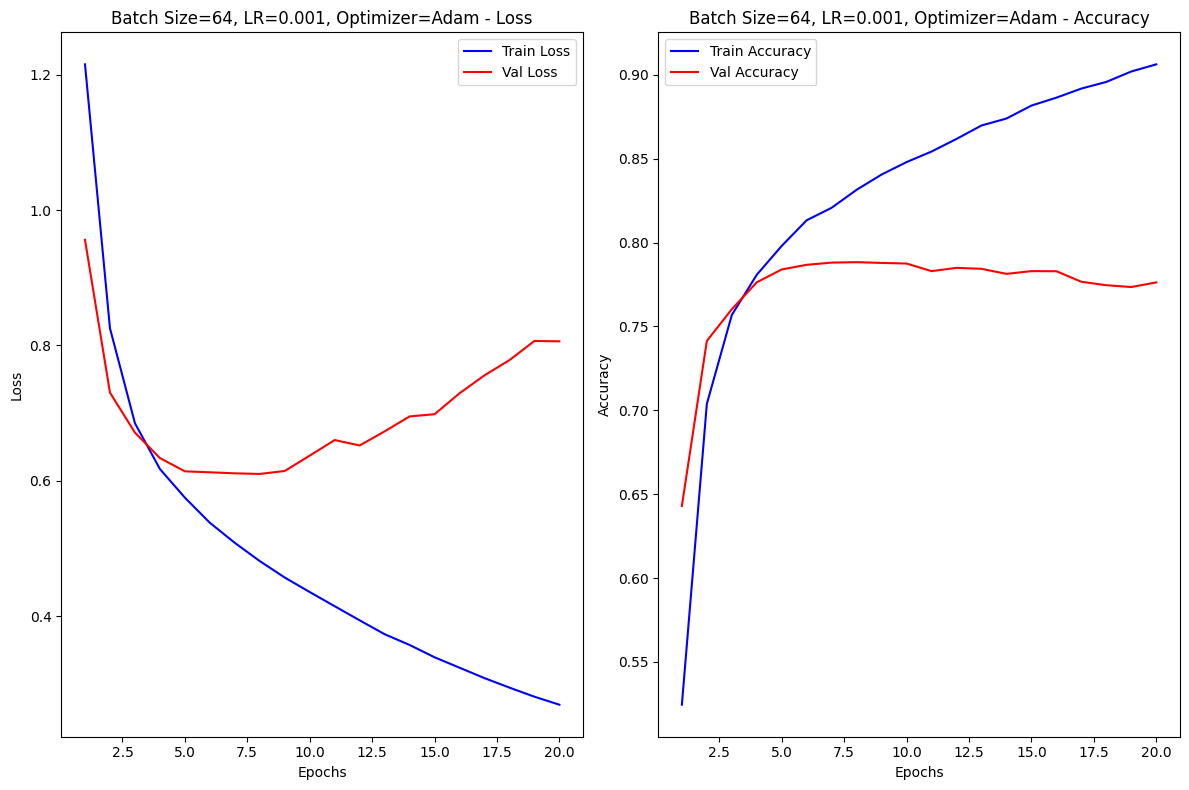

Test Loss: 0.8026, Test Accuracy: 0.7691


In [77]:
model = CNNLSTM(embedding_dim, num_classes).to(device)
trained_model = train_and_evaluate(model, train_dataset, val_dataset, test_dataset, 64, 0.001, optim.Adam, 20)

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1d = nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * (32 // 2), 100)  
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(100, num_classes)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1d(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN(embedding_dim, num_classes).to(device)
summary(cnn_model, input_size=(64, 32, embedding_dim))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [64, 6]                   --
├─Conv1d: 1-1                            [64, 32, 32]              11,552
├─MaxPool1d: 1-2                         [64, 32, 16]              --
├─Linear: 1-3                            [64, 100]                 51,300
├─Dropout: 1-4                           [64, 100]                 --
├─Linear: 1-5                            [64, 6]                   606
Total params: 63,458
Trainable params: 63,458
Non-trainable params: 0
Total mult-adds (M): 26.98
Input size (MB): 0.98
Forward/backward pass size (MB): 0.58
Params size (MB): 0.25
Estimated Total Size (MB): 1.82

### Train Simple CNN

Epoch 1/10, Train Loss: 1.2520, Train Accuracy: 0.5067, Val Loss: 1.1786, Val Accuracy: 0.5420
Epoch 2/10, Train Loss: 1.1455, Train Accuracy: 0.5602, Val Loss: 1.1414, Val Accuracy: 0.5619
Epoch 3/10, Train Loss: 1.0856, Train Accuracy: 0.5860, Val Loss: 1.0922, Val Accuracy: 0.5821
Epoch 4/10, Train Loss: 1.0423, Train Accuracy: 0.6046, Val Loss: 1.1140, Val Accuracy: 0.5777
Epoch 5/10, Train Loss: 1.0127, Train Accuracy: 0.6204, Val Loss: 1.0887, Val Accuracy: 0.5934
Epoch 6/10, Train Loss: 0.9886, Train Accuracy: 0.6302, Val Loss: 1.0778, Val Accuracy: 0.5978
Epoch 7/10, Train Loss: 0.9696, Train Accuracy: 0.6365, Val Loss: 1.0566, Val Accuracy: 0.6071
Epoch 8/10, Train Loss: 0.9539, Train Accuracy: 0.6454, Val Loss: 1.0734, Val Accuracy: 0.6034
Epoch 9/10, Train Loss: 0.9420, Train Accuracy: 0.6497, Val Loss: 1.0563, Val Accuracy: 0.6098
Epoch 10/10, Train Loss: 0.9297, Train Accuracy: 0.6538, Val Loss: 1.0600, Val Accuracy: 0.6057


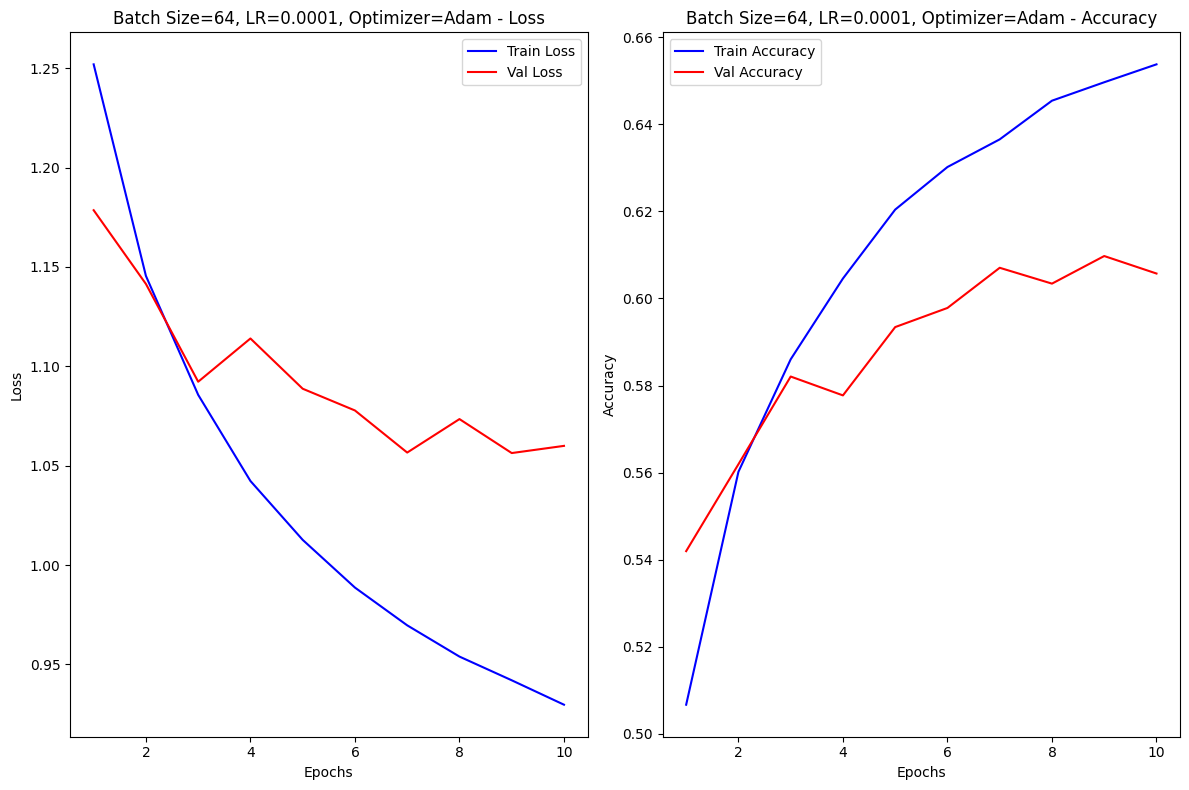

Test Loss: 1.0715, Test Accuracy: 0.5992


In [46]:
trained_cnn_model = train_and_evaluate(cnn_model, train_dataset, val_dataset, test_dataset, 64, 0.001, optim.Adam)

In [87]:
class SimpleLSTM(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SimpleLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=100, batch_first=True)
        self.dropout = nn.Dropout(p=0.1)
        self.fc = nn.Linear(100, num_classes)
        
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        x = self.fc(x)
        return x
    
lstm_model = SimpleLSTM(embedding_dim, num_classes).to(device)
summary(lstm_model, input_size=(64, 32, embedding_dim))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleLSTM                               [64, 6]                   --
├─LSTM: 1-1                              [64, 32, 100]             88,800
├─Dropout: 1-2                           [64, 100]                 --
├─Linear: 1-3                            [64, 6]                   606
Total params: 89,406
Trainable params: 89,406
Non-trainable params: 0
Total mult-adds (M): 181.90
Input size (MB): 0.98
Forward/backward pass size (MB): 1.64
Params size (MB): 0.36
Estimated Total Size (MB): 2.98

### Train Simple LSTM

Epoch 1/10, Train Loss: 1.1894, Train Accuracy: 0.5384, Val Loss: 0.9076, Val Accuracy: 0.6674
Epoch 2/10, Train Loss: 0.7861, Train Accuracy: 0.7198, Val Loss: 0.7150, Val Accuracy: 0.7487
Epoch 3/10, Train Loss: 0.6406, Train Accuracy: 0.7770, Val Loss: 0.6571, Val Accuracy: 0.7732
Epoch 4/10, Train Loss: 0.5660, Train Accuracy: 0.8037, Val Loss: 0.6050, Val Accuracy: 0.7887
Epoch 5/10, Train Loss: 0.5154, Train Accuracy: 0.8210, Val Loss: 0.6034, Val Accuracy: 0.7917
Epoch 6/10, Train Loss: 0.4729, Train Accuracy: 0.8379, Val Loss: 0.5973, Val Accuracy: 0.7975
Epoch 7/10, Train Loss: 0.4336, Train Accuracy: 0.8518, Val Loss: 0.6054, Val Accuracy: 0.7965
Epoch 8/10, Train Loss: 0.3998, Train Accuracy: 0.8630, Val Loss: 0.6010, Val Accuracy: 0.8009
Epoch 9/10, Train Loss: 0.3700, Train Accuracy: 0.8727, Val Loss: 0.6173, Val Accuracy: 0.7979
Epoch 10/10, Train Loss: 0.3407, Train Accuracy: 0.8836, Val Loss: 0.6497, Val Accuracy: 0.7932


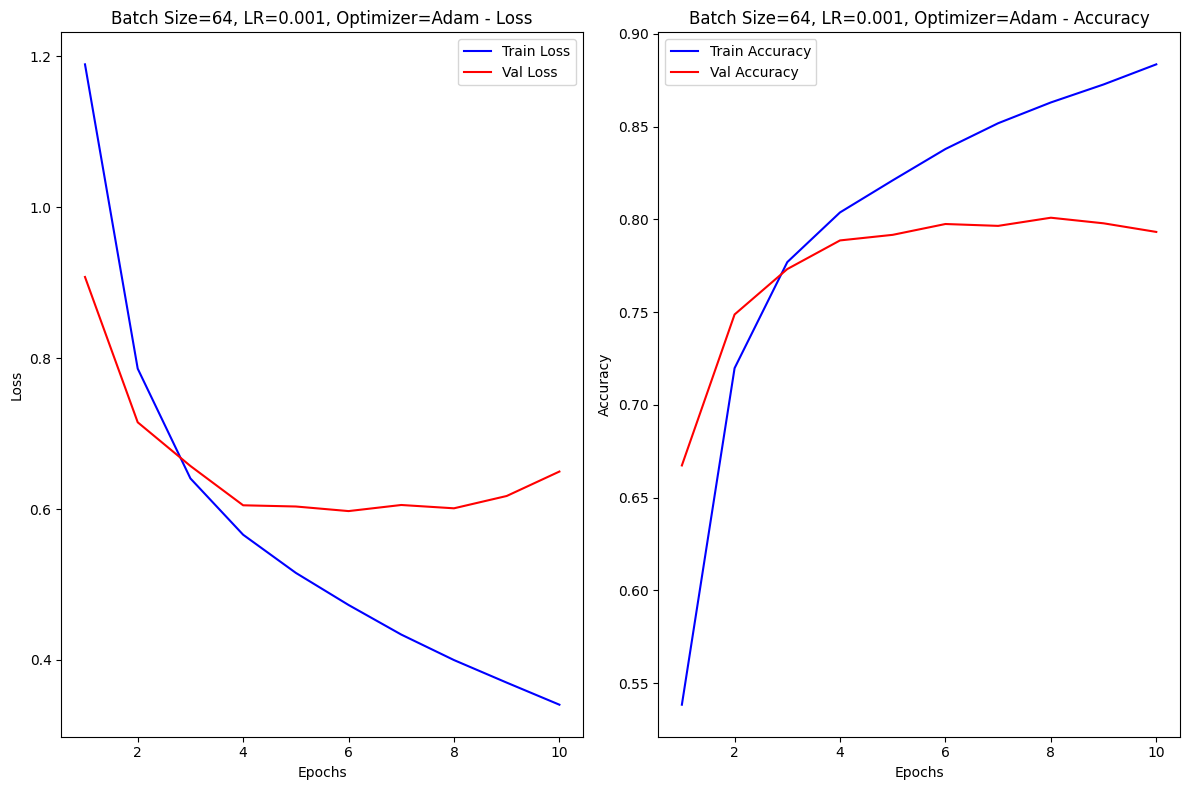

Test Loss: 0.6553, Test Accuracy: 0.7884


In [88]:
trained_lstm_model = train_and_evaluate(lstm_model, train_dataset, val_dataset, test_dataset, 64, 0.001, optim.Adam)

# Classification Report

In [89]:
def print_metrics(model, dataloader, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in dataloader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    
    print(f"{model_name} Model:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {report['macro avg']['precision']:.4f}")
    print(f"Recall: {report['macro avg']['recall']:.4f}")
    print(f"F1-score: {report['macro avg']['f1-score']:.4f}")
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['emotion'].unique(), yticklabels=data['emotion'].unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.show()
    
    return accuracy, report, all_labels, all_preds

In [90]:
def compare_averaging_methods(report, all_labels, all_preds, model_name):
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    micro_avg = {
        'precision': precision,
        'recall': recall,
        'f1-score': f1_score
    }

    print(f"\n{model_name} Model Averaging Comparison:")
    print(f"Macro Averaging - Precision: {macro_avg['precision']:.4f}, Recall: {macro_avg['recall']:.4f}, F1-score: {macro_avg['f1-score']:.4f}")
    print(f"Micro Averaging - Precision: {micro_avg['precision']:.4f}, Recall: {micro_avg['recall']:.4f}, F1-score: {micro_avg['f1-score']:.4f}")
    print(f"Weighted Averaging - Precision: {weighted_avg['precision']:.4f}, Recall: {weighted_avg['recall']:.4f}, F1-score: {weighted_avg['f1-score']:.4f}")

CNN-LSTM Model:
Accuracy: 0.7691
Precision: 0.7591
Recall: 0.7391
F1-score: 0.7483


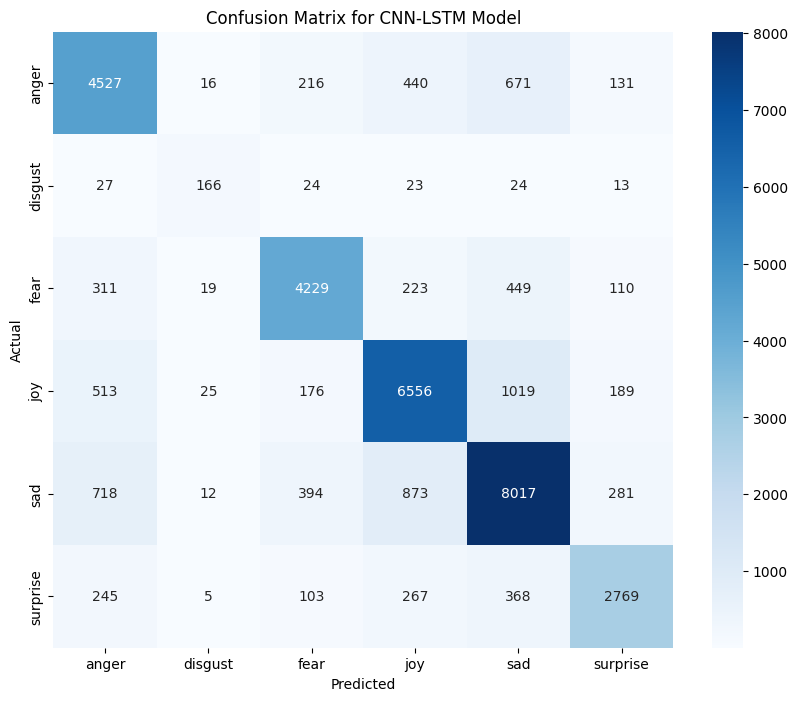

Simple CNN Model:
Accuracy: 0.5992
Precision: 0.5608
Recall: 0.5327
F1-score: 0.5416


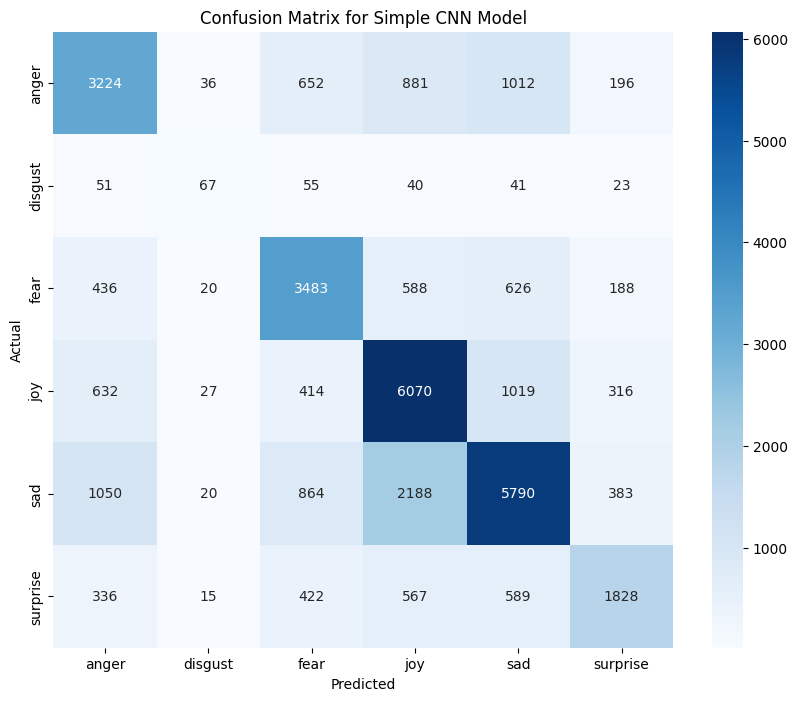

Simple LSTM Model:
Accuracy: 0.7884
Precision: 0.7753
Recall: 0.7563
F1-score: 0.7637


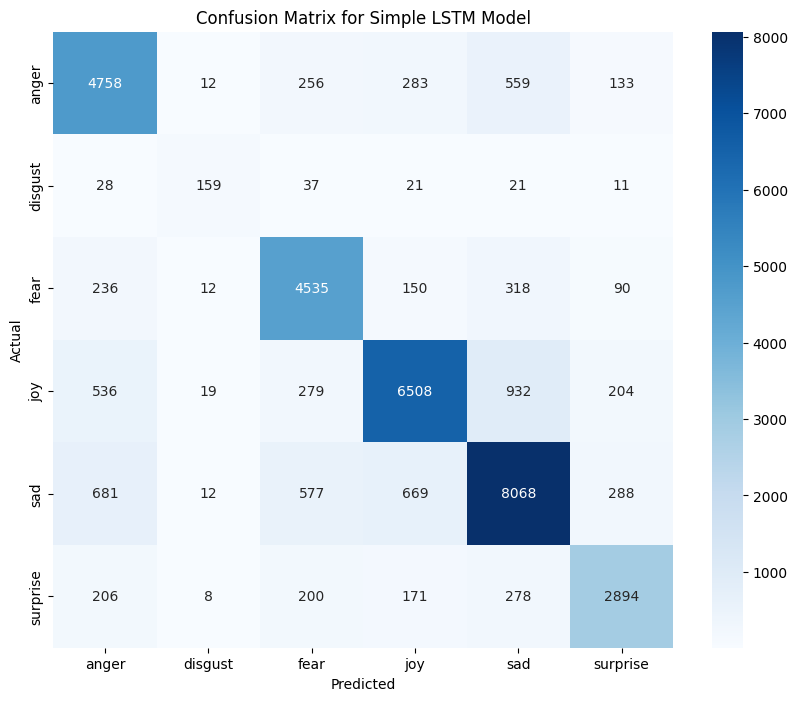

In [91]:
# CNN-LSTM Model
cnn_lstm_accuracy, cnn_lstm_report, cnn_lstm_labels, cnn_lstm_preds = print_metrics(trained_model, test_dataloader, "CNN-LSTM")

# CNN Model
cnn_accuracy, cnn_report, cnn_labels, cnn_preds = print_metrics(trained_cnn_model, test_dataloader, "Simple CNN")

# LSTM Model
lstm_accuracy, lstm_report, lstm_labels, lstm_preds = print_metrics(trained_lstm_model, test_dataloader, "Simple LSTM")

In [92]:
compare_averaging_methods(cnn_lstm_report, cnn_lstm_labels, cnn_lstm_preds, "CNN-LSTM")
compare_averaging_methods(cnn_report, cnn_labels, cnn_preds, "Simple CNN")
compare_averaging_methods(lstm_report, lstm_labels, lstm_preds, "Simple LSTM")


CNN-LSTM Model Averaging Comparison:
Macro Averaging - Precision: 0.7591, Recall: 0.7391, F1-score: 0.7483
Micro Averaging - Precision: 0.7691, Recall: 0.7691, F1-score: 0.7691
Weighted Averaging - Precision: 0.7702, Recall: 0.7691, F1-score: 0.7693

Simple CNN Model Averaging Comparison:
Macro Averaging - Precision: 0.5608, Recall: 0.5327, F1-score: 0.5416
Micro Averaging - Precision: 0.5992, Recall: 0.5992, F1-score: 0.5992
Weighted Averaging - Precision: 0.6010, Recall: 0.5992, F1-score: 0.5965

Simple LSTM Model Averaging Comparison:
Macro Averaging - Precision: 0.7753, Recall: 0.7563, F1-score: 0.7637
Micro Averaging - Precision: 0.7884, Recall: 0.7884, F1-score: 0.7884
Weighted Averaging - Precision: 0.7902, Recall: 0.7884, F1-score: 0.7883


# Bag of Words

In [53]:
vectorizer = CountVectorizer(max_features=1000)  
X_bow = vectorizer.fit_transform(data['cleaned_tweet']).toarray()
y = data['emotion'].factorize()[0]

print("Shape of Bag of Words features:", X_bow.shape)

Shape of Bag of Words features: (113829, 1000)


In [59]:
data_sampled, _, y_sampled, _ = train_test_split(X_bow, y, test_size=0.8, random_state=42)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(data_sampled, y_sampled, test_size=0.2, random_state=42)

print("Training data shape:", X_train_bow.shape)
print("Test data shape:", X_test_bow.shape)

Training data shape: (18212, 1000)
Test data shape: (4553, 1000)


### Gaussian Naive Bayes

In [60]:
gnb = GaussianNB()
gnb.fit(X_train_bow, y_train_bow)


y_pred_gnb = gnb.predict(X_test_bow)


accuracy_gnb = accuracy_score(y_test_bow, y_pred_gnb)
report_gnb = classification_report(y_test_bow, y_pred_gnb, output_dict=True)

print("Gaussian Naive Bayes Model:")
print(f"Accuracy: {accuracy_gnb:.4f}")
print(f"Precision: {report_gnb['macro avg']['precision']:.4f}")
print(f"Recall: {report_gnb['macro avg']['recall']:.4f}")
print(f"F1-score: {report_gnb['macro avg']['f1-score']:.4f}")

Gaussian Naive Bayes Model:
Accuracy: 0.6804
Precision: 0.6167
Recall: 0.6972
F1-score: 0.6059


### Decision Tree

In [61]:
dt = DecisionTreeClassifier()
dt.fit(X_train_bow, y_train_bow)

y_pred_dt = dt.predict(X_test_bow)

accuracy_dt = accuracy_score(y_test_bow, y_pred_dt)
report_dt = classification_report(y_test_bow, y_pred_dt, output_dict=True)

print("Decision Tree Model:")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {report_dt['macro avg']['precision']:.4f}")
print(f"Recall: {report_dt['macro avg']['recall']:.4f}")
print(f"F1-score: {report_dt['macro avg']['f1-score']:.4f}")

Decision Tree Model:
Accuracy: 0.8684
Precision: 0.8781
Recall: 0.8851
F1-score: 0.8814


### Gradient Boosting

In [62]:
gb = GradientBoostingClassifier()
gb.fit(X_train_bow, y_train_bow)

y_pred_gb = gb.predict(X_test_bow)

accuracy_gb = accuracy_score(y_test_bow, y_pred_gb)
report_gb = classification_report(y_test_bow, y_pred_gb, output_dict=True)

print("Gradient Boosting Model:")
print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {report_gb['macro avg']['precision']:.4f}")
print(f"Recall: {report_gb['macro avg']['recall']:.4f}")
print(f"F1-score: {report_gb['macro avg']['f1-score']:.4f}")

Gradient Boosting Model:
Accuracy: 0.8886
Precision: 0.9197
Recall: 0.8964
F1-score: 0.9047


### Random Forest

In [67]:
rf = RandomForestClassifier()
rf.fit(X_train_bow, y_train_bow)

y_pred_rf = rf.predict(X_test_bow)

accuracy_rf = accuracy_score(y_test_bow, y_pred_rf)
report_rf = classification_report(y_test_bow, y_pred_rf, output_dict=True)

print("Random Forest Model:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {report_rf['macro avg']['precision']:.4f}")
print(f"Recall: {report_rf['macro avg']['recall']:.4f}")
print(f"F1-score: {report_rf['macro avg']['f1-score']:.4f}")

Random Forest Model:
Accuracy: 0.8935
Precision: 0.9047
Recall: 0.9039
F1-score: 0.9038


### Logistic Regression

In [68]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_bow, y_train_bow)

y_pred_log_reg = log_reg.predict(X_test_bow)

accuracy_log_reg = accuracy_score(y_test_bow, y_pred_log_reg)
report_log_reg = classification_report(y_test_bow, y_pred_log_reg, output_dict=True)

print("Logistic Regression Model:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {report_log_reg['macro avg']['precision']:.4f}")
print(f"Recall: {report_log_reg['macro avg']['recall']:.4f}")
print(f"F1-score: {report_log_reg['macro avg']['f1-score']:.4f}")

Logistic Regression Model:
Accuracy: 0.8902
Precision: 0.9054
Recall: 0.9011
F1-score: 0.9029


In [69]:
cm = confusion_matrix(y_test_bow, y_pred_log_reg)

In [70]:
cm

array([[ 716,    0,    8,   52,   52,    7],
       [   0,   36,    0,    1,    0,    0],
       [   6,    0,  658,    8,   32,    7],
       [  37,    2,    7,  939,   53,   12],
       [  50,    0,    9,   72, 1262,   12],
       [  20,    0,    6,   26,   21,  442]])